# Bayesian Network Structure Learning in Pomegranate

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com
    
Learning the structure of Bayesian networks can be complicated for two main reasons: (1) difficulties in inferring causality and (2) the sheer number of possible causal interactions which can take place in a dataset. The first point is a result of most methods only determining correlation or co-occurance between two variables instead of some type of causal statement. The second point is because there are a super-exponential number of directed acyclic graphs which could possibly be used, and this can become an intractable problem very quickly.

The first point presents challenges which deserve a far more in depth treatment unrelated to implementations in pomegranate, so instead this tutorial will focus on how pomegranate implements fast Bayesian network structure learning. It will also cover a new concept called the "constraint graph" which can be used to massively speed up structure search while also making causality assignment a bit more reasonable.

## Introduction to Bayesian Network Structure Learning

Three ways that have arisen for doing structure learning (BNSL) are described below:

(1) Search and Score: This method is fairly simple conceptually. The idea is to search over all possible directed acyclic graphs (DAGs) and score them according to some objective function chosen ahead of time (such as Bayesian information criterion (BIC)/minimum description length (MDL)) and then simply choose the DAG which has the best score. This will yield a globally optimal graph but is super-exponential in time with the number of variables in the network. However, dynamic programming can efficiently remove the many repeated calculations and reduce this to be simply exponential in time. This allows exact BNSL to scale to ~25-30 variables.

(2) Constraint learning: This method begins with a dense undirected graph and trims off edges which are determined to be conditionally independent of each other. Ultimately it iterates over v-structures to determine these conditional independencies. This algorithm is asymptotically faster (quadratic in time) than search-and-score, but it does not have a probabilistic interpretation and can suffer similar problems with determining the correct direction of the edges.

(3) Approximate algorithms: Given the attractiveness of the interpretation of search-and-score and the attractiveness of it not taking forever to run, much work has been done in producing approximate algorithms which run fast and produce a good estimate of the posterior of the distribution being modelled. These include the Chow-Liu tree building algorithm, the hill-climbing algorithm, and optimal reinsertion, though there are others.

pomegranate currently implements a search-and-score method based on the minimum description length score which utilizes the dynamic programming algorithm, and the Chow-Liu tree building algorithm, though there are plans to soon add other algorithms.

## Structure Learning in pomegranate
### Exact Learning

Structure learning in pomegranate is done using the `from_samples` method. All you pass in is the samples, their associated weights (if not uniform), and the algorithm which you'd like to use, and it will learn the network for you using the dynamic programming implementation. Lets see a quick synthetic example to make sure that appropriate connections are found. Lets add connections between variables 1, 3, 6, and variables 0 and 2, and variables 4 and 5.

In [1]:
%pylab inline
from pomegranate import BayesianNetwork
import seaborn, time
seaborn.set_style('whitegrid')

n, d = 2000, 7
X = numpy.zeros((n, d))

idx = numpy.array(numpy.random.randint(2, size=(n,)), dtype=bool)
X[idx, 1] = 1
X[idx, 3] = 1
X[:, 6] = 1
X[idx, 6] = 0

idx = numpy.array(numpy.random.randint(2, size=(n,)), dtype=bool)
X[idx, 0] = 1
X[idx, 2] = 1

idx = numpy.array(numpy.random.randint(2, size=(n,)), dtype=bool)
X[idx, 4] = 1
X[:, 5] = 1
X[idx, 5] = 0
    
model = BayesianNetwork.from_samples(X, algorithm='exact')
print model.structure

Populating the interactive namespace from numpy and matplotlib
((), (3,), (0,), (), (), (4,), (1,))


The structure attribute returns a tuple of tuples, where each inner tuple corresponds to that node in the graph (and the column of data learned on). The numbers in that inner tuple correspond to the parents of that node. The results from this structure are that node 1 has node 3 as a parent, that node 2 has node 0 as a parent, and so forth. It seems to faithfully recapture the underlying dependencies in the data.

For future examples, we will just work with purely random data, as it algorithmically takes the same amount of time if the data is structured or not but takes more effort to come up with randomly generated data.

Lets look at how long it takes to do structure learning.

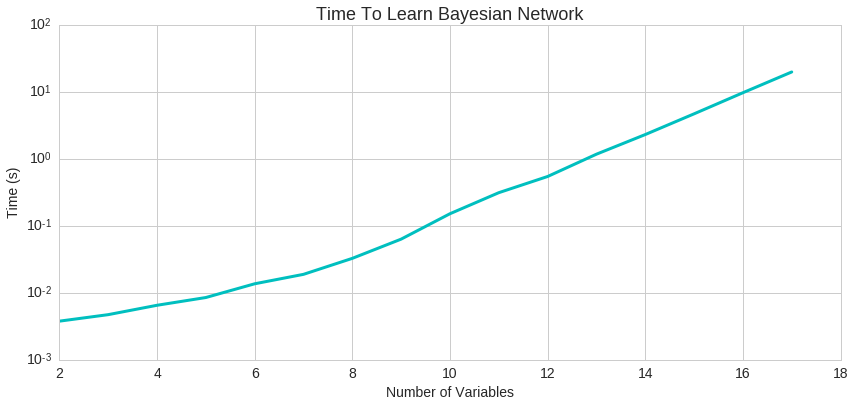

In [2]:
times = []
for i in range(2, 18):
    tic = time.time()
    X = numpy.random.randint(2, size=(2000, i))
    model = BayesianNetwork.from_samples(X, algorithm='exact') # << BNSL done here!
    times.append( time.time() - tic )


plt.figure(figsize=(14, 6))
plt.title('Time To Learn Bayesian Network', fontsize=18)
plt.xlabel("Number of Variables", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot( range(2, 18), times, linewidth=3, color='c')
plt.yscale('log')

This pretty much confirms that the algorithm is simply exponential in time instead of super-exponential in time like most exact learning algorithms. It also seems like it's a reasonable amount of time, with 17 variables only taking ~10 seconds to do. It would be feasible to do up to 25 variables.

### Approximate Learning: Chow Liu Trees

Sometimes you want to quickly get a Bayesian network which is only an approximation of the distribution. This can be for a variety of reasons--perhaps the data is so separable that a complicated graph isn't needed, or perhaps you want to look at strongest effects. In this case, a Chow-Liu Tree can be constructed, which is a Bayesian network with a tree structure, meaning that no nodes can have more than one parents and no cycles are formed.

This algorithm is extremely efficient over large numbers of variables as it is only quadratic in time with the number of variables. The essence behind this algorithm is that the pairwise mutual information is calculated for each pair of variables and then a maximum spanning tree is constructed from a user specified root to encapsulate all variables. Edges are oriented away from the user specified root. Lets take a look at the previous data and see what we get.

In [3]:
n, d = 2000, 7
X = numpy.zeros((n, d))

idx = numpy.array(numpy.random.randint(2, size=(n,)), dtype=bool)
X[idx, 1] = 1
X[idx, 3] = 1
X[:, 6] = 1
X[idx, 6] = 0

idx = numpy.array(numpy.random.randint(2, size=(n,)), dtype=bool)
X[idx, 0] = 1
X[idx, 2] = 1

idx = numpy.array(numpy.random.randint(2, size=(n,)), dtype=bool)
X[idx, 4] = 1
X[:, 5] = 1
X[idx, 5] = 0
    
model = BayesianNetwork.from_samples(X, algorithm='chow-liu')
print model.structure

((), (0,), (0,), (1,), (0,), (4,), (1,))


The results are a bit more difficult to interpret since a tree structure is enforced, but we can see they match the data. 1, 3, and 6 are supposed to be connected, and we see 1 is a parent of both 3 and 6. 0 and 2 are supposed to be connected and 0 is a parent of 2. 4 and 5 are supposed to be connected and 5 is a parent of 4. There are other algorithms which calculate a 'forest' of trees across variables so that spurious connections are not requires to keep everything together, and pomegranate will support this in the future.

Now, this assumed that the root was variable 0. You can specify any node you'd like to be the root like this:

In [4]:
model = BayesianNetwork.from_samples(X, algorithm='chow-liu', root=6)
print model.structure

((6,), (6,), (0,), (6,), (0,), (4,), ())


The same connections are still in place.

## Constraint Graphs

Now, sometimes you have prior information about how groups of nodes are connected to each other and want to exploit that. This can take the form of a global ordering, where variables can be ordered in such a manner that edges only go from left to right, for example. However, sometimes you have layers in your network where variables are a part of these layers and can only have parents in another layer.

Lets consider a diagnostics Bayesian network like the following (no need to read code, the picture is all that is important for now):

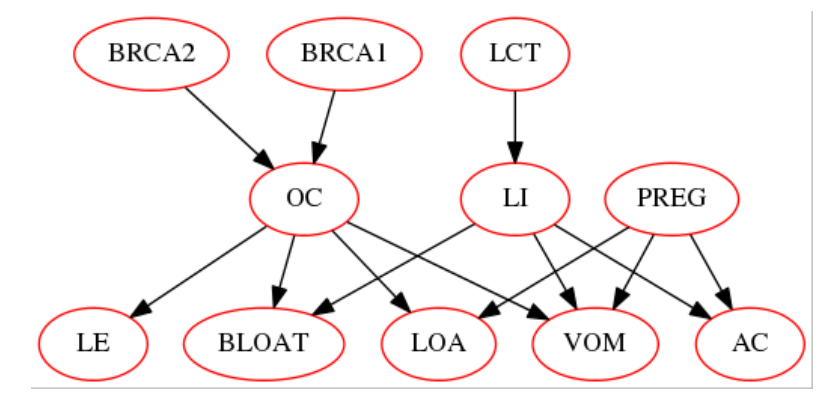

In [5]:
from pomegranate import DiscreteDistribution, ConditionalProbabilityTable, Node

BRCA1 = DiscreteDistribution({0: 0.999, 1: 0.001})
BRCA2 = DiscreteDistribution({0: 0.985, 1: 0.015})
LCT   = DiscreteDistribution({0: 0.950, 1: 0.050})

OC = ConditionalProbabilityTable([[0, 0, 0, 0.999],
                                  [0, 0, 1, 0.001],
                                  [0, 1, 0, 0.750],
                                  [0, 1, 1, 0.250],
                                  [1, 0, 0, 0.700],
                                  [1, 0, 1, 0.300],
                                  [1, 1, 0, 0.050],
                                  [1, 1, 1, 0.950]], [BRCA1, BRCA2])

LI = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.20],
                                  [1, 1, 0.80]], [LCT])

PREG = DiscreteDistribution({0: 0.90, 1: 0.10})

LE = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.25],
                                  [1, 1, 0.75]], [OC])

BLOAT = ConditionalProbabilityTable([[0, 0, 0, 0.85],
                                     [0, 0, 1, 0.15],
                                     [0, 1, 0, 0.70],
                                     [0, 1, 1, 0.30],
                                     [1, 0, 0, 0.40],
                                     [1, 0, 1, 0.60],
                                     [1, 1, 0, 0.10],
                                     [1, 1, 1, 0.90]], [OC, LI])

LOA = ConditionalProbabilityTable([[0, 0, 0, 0.99],
                                   [0, 0, 1, 0.01],
                                   [0, 1, 0, 0.30],
                                   [0, 1, 1, 0.70],
                                   [1, 0, 0, 0.95],
                                   [1, 0, 1, 0.05],
                                   [1, 1, 0, 0.95],
                                   [1, 1, 1, 0.05]], [PREG, OC])

VOM = ConditionalProbabilityTable([[0, 0, 0, 0, 0.99],
                                   [0, 0, 0, 1, 0.01],
                                   [0, 0, 1, 0, 0.80],
                                   [0, 0, 1, 1, 0.20],
                                   [0, 1, 0, 0, 0.40],
                                   [0, 1, 0, 1, 0.60],
                                   [0, 1, 1, 0, 0.30],
                                   [0, 1, 1, 1, 0.70],
                                   [1, 0, 0, 0, 0.30],
                                   [1, 0, 0, 1, 0.70],
                                   [1, 0, 1, 0, 0.20],
                                   [1, 0, 1, 1, 0.80],
                                   [1, 1, 0, 0, 0.05],
                                   [1, 1, 0, 1, 0.95],
                                   [1, 1, 1, 0, 0.01],
                                   [1, 1, 1, 1, 0.99]], [PREG, OC, LI])

AC = ConditionalProbabilityTable([[0, 0, 0, 0.95],
                                  [0, 0, 1, 0.05],
                                  [0, 1, 0, 0.01],
                                  [0, 1, 1, 0.99],
                                  [1, 0, 0, 0.40],
                                  [1, 0, 1, 0.60],
                                  [1, 1, 0, 0.20],
                                  [1, 1, 1, 0.80]], [PREG, LI])

s1 = Node(BRCA1, name="BRCA1")
s2 = Node(BRCA2, name="BRCA2")
s3 = Node(LCT, name="LCT")
s4 = Node(OC, name="OC")
s5 = Node(LI, name="LI")
s6 = Node(PREG, name="PREG")
s7 = Node(LE, name="LE")
s8 = Node(BLOAT, name="BLOAT")
s9 = Node(LOA, name="LOA")
s10 = Node(VOM, name="VOM")
s11 = Node(AC, name="AC")

model = BayesianNetwork("Hut")
model.add_nodes(s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
model.add_edge(s1, s4)
model.add_edge(s2, s4)
model.add_edge(s3, s5)
model.add_edge(s4, s7)
model.add_edge(s4, s8)
model.add_edge(s4, s9)
model.add_edge(s4, s10)
model.add_edge(s5, s8)
model.add_edge(s5, s10)
model.add_edge(s5, s11)
model.add_edge(s6, s9)
model.add_edge(s6, s10)
model.add_edge(s6, s11)
model.bake()

plt.figure(figsize=(14, 10))
model.plot()
plt.show()

This network contains three layer, with symptoms on the bottom (low energy, bloating, loss of appetite, vomitting, and abdominal cramps), diseases in the middle (overian cancer, lactose intolerance, and pregnancy), and genetic tests on the top for three different genetic mutations. The edges in this graph are constrainted such that symptoms are explained by diseases, and diseases can be partially explained by genetic mutations. There are no edges from diseases to genetic conditions, and no edges from genetic conditions to symptoms. If we were going to design a more efficient search algorithm, we would want to exploit this fact to drastically reduce the search space of graphs.

Before presenting a solution, lets also consider another situation. In some cases you can define a global ordering of the variables, meaning you can order them from left to right and ensure that edges only go from the left to the right. This can represent some temporal separation (things on the left happen before things on the right), physical separation, or anything else. This would also dramatically reduce the search space. 

In addition to reducing the search space, an efficient algorithm can exploit this layered structure. A key property of most scoring functions is the idea of "global parameter independence", meaning that that the parents of node A are independent of the parents of node B assuming that they do not form a cycle in the graph. If you have a layered structure, either like in the diagnostics network or through a global ordering, it is impossible to form a cycle in the graph through any valid assignment of parent values. This means that the parents for each node can be identified independently, drastically reducing the runtime of the algorithm.

Now, sometimes we know ~some things~ about the structure of the variables, but nothing about the others. For example, we might have a partial ordering on some variables but not know anything about the others. We could enforce an arbitrary ordering on the others, but this may not be well justified. In essence, we'd like to exploit whatever information we have.

Abstractly, we can think about this in terms of constraint graphs. Lets say you have some symptoms, diseases, and genetic tests, and don't a priori know the connection between all of these pieces, but you do know the previous layer structure. You can define a "constraint graph" which is made up of three nodes, "symptoms", "diseases", and "genetic mutations". There is a directed edge from genetic mutations to diseases, and a directed edge from diseases to symptoms. This specifies that genetic mutations can be parents to diseases, and diseases to symptoms. It would look like the following:

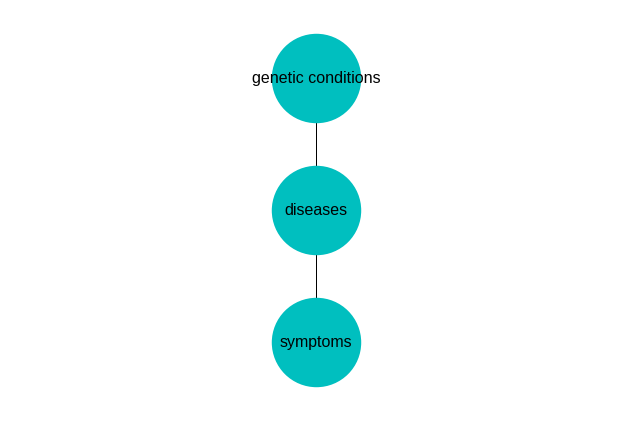

In [6]:
import networkx
constraints = networkx.DiGraph()
constraints.add_edge('genetic conditions', 'diseases')
constraints.add_edge('diseases', 'symptoms')

networkx.draw(constraints, {'genetic conditions': (0, 3), 'diseases': (0, 2), 'symptoms': (0, 1)},
              node_color='c', node_size=8000, with_labels=True, font_size=16, linewidths=0)

All variables corresponding to these categories would be put in their appropriate name. This would define a scaffold for structure learning.

Now, we can do the same thing for a global ordering. Lets say we have 3 variables in an order from 0-2. 

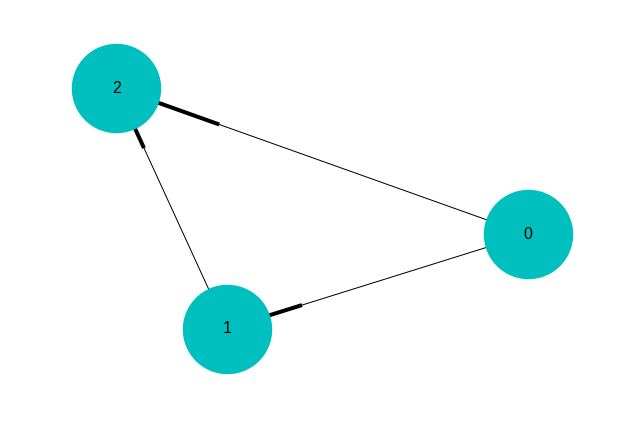

In [7]:
constraints = networkx.DiGraph()
constraints.add_edge(0, 1)
constraints.add_edge(1, 2)
constraints.add_edge(0, 2)
networkx.draw(constraints, node_color='c', node_size=8000, with_labels=True, font_size=16, linewidths=0)

In this graph, we're saying that variable 0 can be a parent for 1 or 2, and that variable 1 can be a parent for variable 2. In the same way that putting multiple variables in a node of the constraint graph allowed us to define layers, putting a single variable in the nodes of a constraint graph can allow us to define an ordering.

To be specific, lets say we want to find the parents of the variables in node 1 given that those variables parents can only come from the variables in node 0. We can independently find the best parents for each variable in node 1 from the set of those in node 0. This is significantly faster than trying to find the best Bayesian network of all variables in nodes 0 and 1. We can also do the same thing for the variables in node 2 by going through the variables in both nodes 0 and 1 to find the best parent set for the variables in node 2.

However, there are some cases where we know nothing about the parent structure of some variables. This can be solved by including self-loops in the graph, where a node is its own parent. This means that we know nothing about the parent structure of the variables in that node and that the full exponential time algorithm will have to be run. The naive structure learning algorithm can be thought of as putting all variables in a single node in the constraint graph and putting a self-loop on that node. 

We are thus left with two procedures; one for solving edges which are self edges, and one for solving edges which are not. Even though we have to use the exponential time procedure on variables in nodes with self loops, it will still be significantly faster because we will be using less variables (except in the naive case).

Frequently though we will have some information about some of the nodes of the graph even if we don't have information about all of the nodes. Lets take the case where we know some variables have no children but can have parents, and know nothing about the other variables.

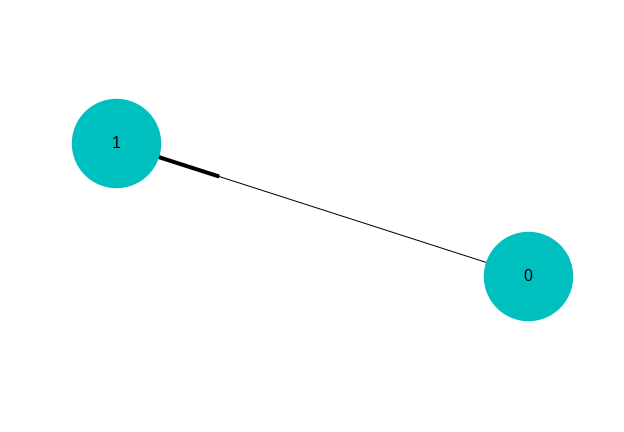

In [8]:
constraints = networkx.DiGraph()
constraints.add_edge(0, 1)
constraints.add_edge(0, 0)
networkx.draw(constraints, node_color='c', node_size=8000, with_labels=True, font_size=16, linewidths=0)

In this case networkx doesn't know how to draw self loops, but we're saying that 0 is a parent of both 0 and 1. In this situation we would have to run the exponential time algorithm on the variables in node 0 to find the optimal parents, and then run the independent parents algorithm on the variables in node 1 drawing only from the variables in node 0. To be specific:

(1) Use exponential time procedure to find optimal structure amongst variables in node 0 
(2) Use independent-parents procedure to find the best parents of variables in node 1, restricting the parents to be in node 0
(3) Concatenate these parent sets together to get the optimal structure of the network given the constraints.

We can generalize this to any arbitrary constraint graph:

(1) Use exponential time procedure to find optimal structure amongst variables in nodes with self loops (including parents from other nodes if needed)
(2) Use independent-parents procedure to find best parents of variables in a node given the constraint that the parents must come from variables in the node which is this nodes parent
(3) Concatenate these parent sets together to get the optimal structure of the network given the constraints.

According to the global parameter independence property of Bayesian networks, this procedure will give the globally optimal Bayesian network while exploring a significantly smaller part of the network.

pomegranate supports constraint graphs in an extremely easy to use manner. Lets say that we have a graph with three layers like the diagnostic model, and five variables in each layer. We can define the constraint graph as a networkx DiGraph, with the nodes being tuples containing the column ids of each variable belonging to that variable.

In this case, we're saying that (0, 1, 2, 3, 4) is the first node, (5, 6, 7, 8, 9) is the second node, and (10, 11, 12, 13, 14) is the final node. Lets make nodes 1, 7, and 12 related, 11, 13, 14 related, and 3 and 5 related. In this case, where should be an edge from 1 to 7, and 7 to 12. 11, 13, and 14 are all a part of the same layer and so that connection should be ignored, and then there should be a connection from 3 to 5.

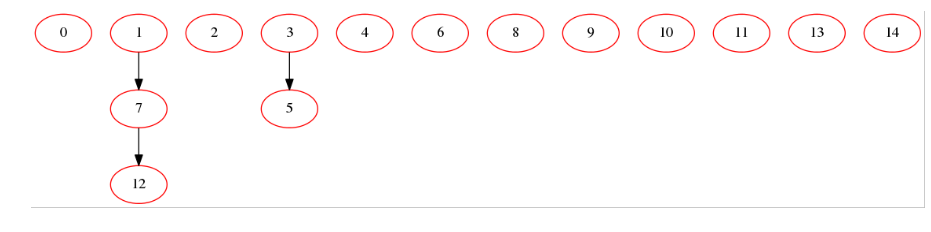

pomegranate time:  0.367755174637 ((), (), (), (), (), (3,), (), (1,), (), (), (), (), (7,), (), ())


In [9]:
numpy.random.seed(0)
random.seed(0)

X = numpy.random.randint(2, size=(2000, 15))

X[500:1500, 1] = 1
X[500:1500, 7] = 1
X[:500, 12] = 1
X[1500:, 12] = 1

idx = numpy.array(numpy.random.randint(2, size=(2000,)), dtype=bool)

X[idx, 14] = 1
X[idx, 13] = 1
X[idx, 11] = 1

idx = numpy.array(numpy.random.randint(2, size=(2000,)), dtype=bool)

X[idx, 3] = 1
X[idx, 5] = 1

a = networkx.DiGraph()
b = tuple((0, 1, 2, 3, 4))
c = tuple((5, 6, 7, 8, 9))
d = tuple((10, 11, 12, 13, 14))

a.add_edge(b, c)
a.add_edge(c, d)


tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact', constraint_graph=a)

plt.figure(figsize=(16, 8))
model.plot()
plt.show()
print "pomegranate time: ", time.time() - tic, model.structure

We see that reconstructed perfectly here. Lets see what would happen if we didn't use the exact algorithm.

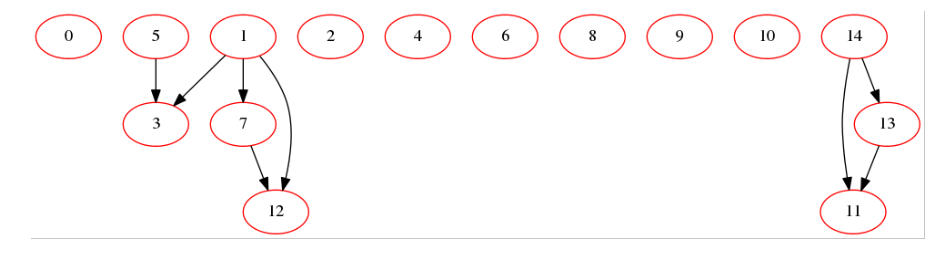

pomegranate time:  5.05336403847 ((), (), (), (1, 5), (), (), (), (1,), (), (), (), (13, 14), (1, 7), (14,), ())


In [10]:
tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact')
plt.figure(figsize=(16, 8))
model.plot()
plt.show()
print "pomegranate time: ", time.time() - tic, model.structure

It looks like we got three desirable attributes by using a constraint graph. The first is that there was over an order of magnitude speed improvement in finding the optimal graph. The second is that we were able to remove some edges we didn't want in the final Bayesian network, such as those between 11, 13, and 14. We also removed the edge between 1 and 12 and 1 and 3, which are spurious given the model that we originally defined. The third desired attribute is that we can specify the direction of some of the edges and get a better causal model.

Lets take a look at how big of a model we can learn given a three layer constraint graph like before. 

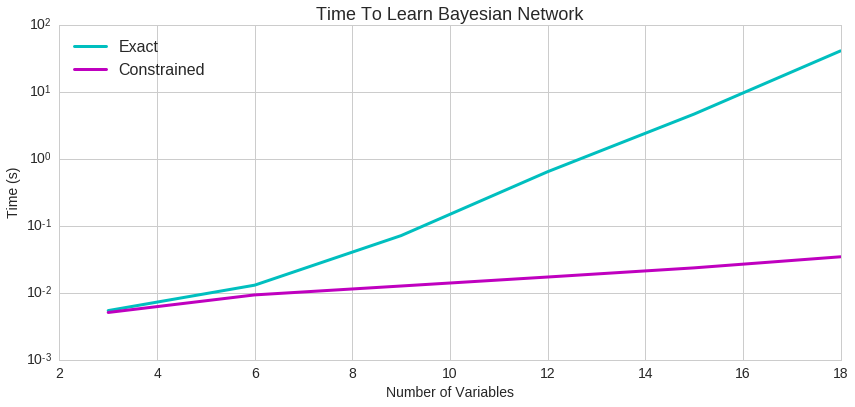

In [11]:
constraint_times, times = [], []

x = numpy.arange(1, 7)
for i in x:
    symptoms = tuple(range(i))
    diseases = tuple(range(i, i*2))
    genetic = tuple(range(i*2, i*3))

    constraints = networkx.DiGraph()
    constraints.add_edge(genetic, diseases)
    constraints.add_edge(diseases, symptoms)
    
    X = numpy.random.randint(2, size=(2000, i*3))
    
    tic = time.time()
    model = BayesianNetwork.from_samples(X, algorithm='exact', constraint_graph=constraints)
    constraint_times.append( time.time() - tic )
    
    tic = time.time()
    model = BayesianNetwork.from_samples(X, algorithm='exact')
    times.append( time.time() - tic )  


plt.figure(figsize=(14, 6))
plt.title('Time To Learn Bayesian Network', fontsize=18)
plt.xlabel("Number of Variables", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot( x*3, times, linewidth=3, color='c', label='Exact')
plt.plot( x*3, constraint_times, linewidth=3, color='m', label='Constrained')
plt.legend(loc=2, fontsize=16)
plt.yscale('log')

Looks like by including a constraint graph, we can far more quickly find the optimal Bayesian network. This can allow us to create Bayesian networks on dozens of variables as long as we can order them into layers.

## Add-Ons

A side note is that pomegranate currently supports adding pseudocounts to smooth the number of observations through the "pseudocount" keyword. By default this is 0. All algorithms support pseudocounts. Also, exact learning supports a sparse candidate (or k-learn) which limits the maximum number of parents that a node can have. You can limit the maximum number of parents through the "max_parents" keyword. An example of using both is the following:

```
model = BayesianNetwork.from_samples(X, algorithm='exact', pseudocount=1.3, max_parents=2)
```

Since exact inference uses minimum description length as a score function, the maximum number of parents is by default set to $\log(\frac{n}{\log(n)})$ with $n$ being the number of samples in the dataset.

# Conclusions

pomegranate currently supports exact BNSL through an efficient dynamic programming algorithm, the Chow-Liu tree building algorithm, and a constraint-graph based algorithm which can significantly speed up structure learning if you have any prior knowledge of the interactions between variables. The interface for using these functions in pomegranate is very intuitive to use.

If you have any suggestions for how to improve pomegranate or ideas for algorithms to implement, feel free to open an issue on the issue tracker! I'd love to hear feedback.